# Imports

In [1]:
import boto3
import botocore
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import time
from tqdm.notebook import tqdm
import xarray as xr

# Configuration

This defines the years over which we run our analysis. We use 1979-1989 because global warming hadn't kicked in _quite_ so badly, and earlier years aren't present on S3. We use January and July as representative months for the extremes.

In [2]:
MONTHS = [1, 7]
MONTH_NAMES = {1: 'January', 7: 'July'}
YEARS = list(range(1979, 1989))
# YEARS = list(range(1979, 1981)) # Shorter range for testing.

# https://github.com/planet-os/notebooks/blob/3022f6ccc146ce93da54317eaf921a8d8fc8e19a/aws/era5-s3-via-boto.ipynb
era5_bucket = 'era5-pds'
boto_client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

# Helper functions

In [21]:
# https://github.com/planet-os/notebooks/blob/3022f6ccc146ce93da54317eaf921a8d8fc8e19a/aws/era5-pds.md
def data_s3_path(year, month, variable):
    return f'{year}/{month:02}/data/{variable}.nc'

def data_file_name(year, month, variable):
    return f'data/{year}/{month:02}/{variable}.nc'

def load_data(year, month, variable):
    # print(f'Loading {variable} for {year}-{month:02}')
    ds = xr.load_dataset(data_file_name(year, month, variable), engine='h5netcdf')
    # Precipitation files contain two arrays. Pick the one with geospatial data.
    arrays = [arr for arr in ds.data_vars.values() if 'lat' in arr.coords and 'lon' in arr.coords]
    assert len(arrays) == 1
    array = arrays[0]
    # Most files have time0. Precipitation files have time1. Presumably end time, but we don't care.
    if 'time1' in array.coords:
        array = array.rename({'time1': 'time0'})
    return array

def download_data(year, month, variable):
    local_file = data_file_name(year, month, variable)
    os.makedirs(os.path.dirname(local_file), exist_ok=True)
    if os.path.exists(local_file):
        #print(f'{local_file} already exists')
        return
    #print(f'Downloading {local_file}')
    boto_client.download_file(era5_bucket, data_s3_path(year, month, variable), local_file)
    
def average_by_month(years, months, variable):
    result = None
    with tqdm(total=len(years) * len(months)) as bar:
        for month in months:
            num_hours = 0
            month_sum = None
            for year in years:
                data = load_data(year, month, variable)
                data = data.expand_dims('month').assign_coords({'month': [month]})
                year_sum = data.sum(dim='time0')
                if month_sum is None:
                    month_sum = year_sum
                else:
                    month_sum += year_sum
                num_hours += len(data.coords['time0'])
                bar.update(1)
            month_mean = month_sum / num_hours
            if result is None:
                result = month_mean
            else:
                result = xr.concat([result, month_mean], dim='month')
    return result

def plot_map(array, **kwargs):
    for month in MONTHS:
        array.sel(month=month).plot(figsize=(12, 5), **kwargs)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.title(MONTH_NAMES[month])

def plot_by_lat(array, **kwargs):
    plt.figure(figsize=(9, 4))
    mean = array.mean(dim='lon', keep_attrs=True)
    for month in MONTHS:
        mean.sel(month=month).plot(label=MONTH_NAMES[month], **kwargs)
    plt.xticks(np.linspace(-90, 90, 13))
    plt.grid(axis='both')
    plt.legend(loc='upper right')
    plt.title(None)
    plt.tight_layout()

# Download

Download ERA5 datasets from AWS S3 using boto.

In [4]:
VARIABLES = [
    'eastward_wind_at_10_metres',
    'northward_wind_at_10_metres',
    'air_temperature_at_2_metres',
    'precipitation_amount_1hour_Accumulation',
]
with tqdm(total=len(VARIABLES) * len(YEARS) * len(MONTHS)) as bar:
    for variable in VARIABLES:
        for year in YEARS:
            for month in MONTHS:
                download_data(year, month, variable)
                bar.update(1)

  0%|          | 0/80 [00:00<?, ?it/s]

# Wind

In [5]:
eastward_wind = average_by_month(YEARS, MONTHS, 'eastward_wind_at_10_metres')
northward_wind = average_by_month(YEARS, MONTHS, 'northward_wind_at_10_metres')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

## Average wind speed

This calculation is actually quite wrong, because it's not the average of the wind speed, but the length of the average wind vector. In other words, opposing winds cancel each other out. But it'll do for our purposes.

In [6]:
# https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
wind_speed = np.sqrt(eastward_wind**2 + northward_wind**2).rename('wind speed').assign_attrs(units='m/s')

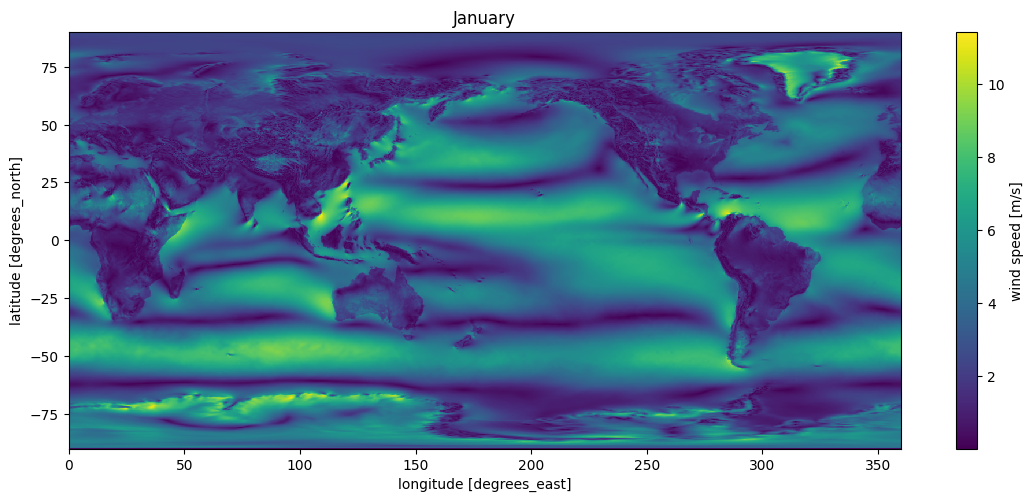

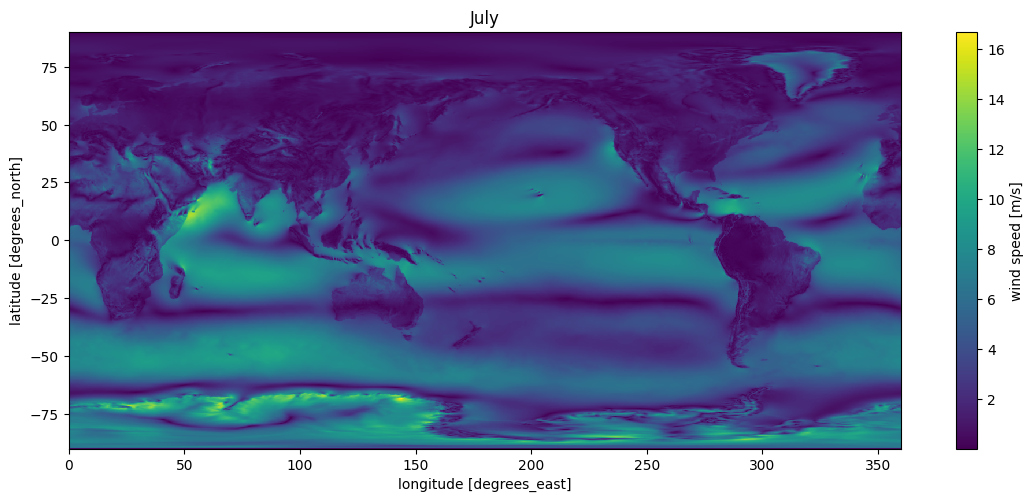

In [7]:
plot_map(wind_speed)

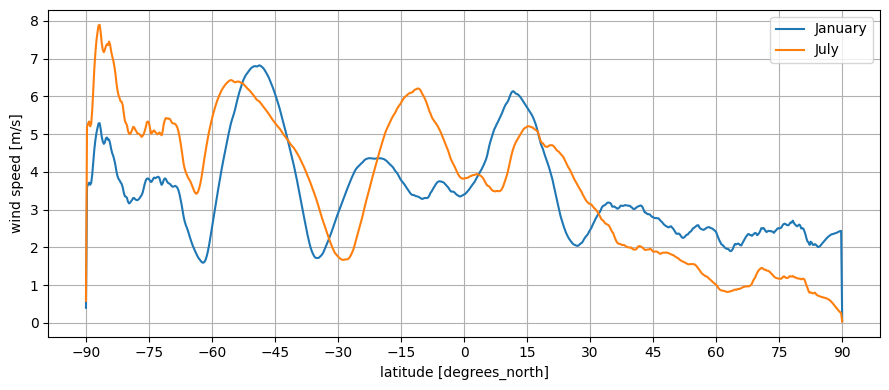

In [22]:
plot_by_lat(wind_speed)

## Average wind bearing

In our world, the bearing is the direction the wind is blowing _towards_. Only weird meteorologists use the angle where the wind is coming _from_.

In [9]:
wind_bearing = (np.rad2deg(np.arctan2(eastward_wind, northward_wind)) % 360).rename('wind_bearing').assign_attrs(units='degrees')

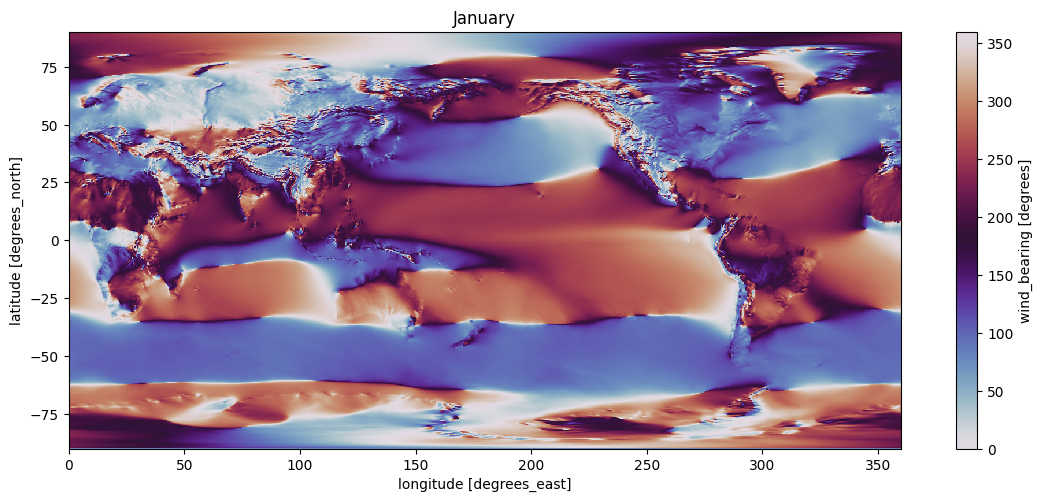

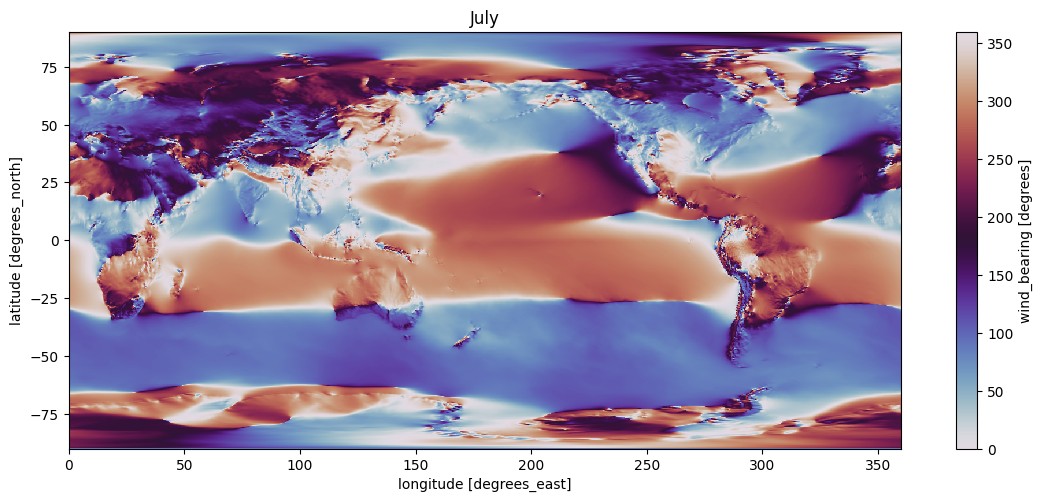

In [10]:
plot_map(wind_bearing, cmap='twilight')

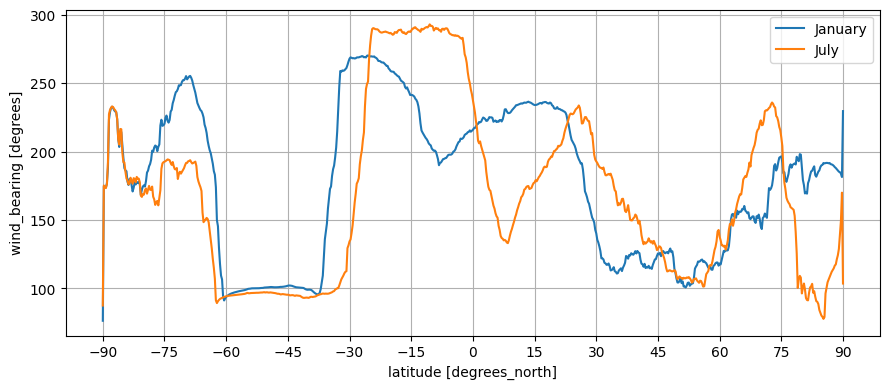

In [23]:
plot_by_lat(wind_bearing)

# Temperature

In [12]:
temperature = (average_by_month(YEARS, MONTHS, 'air_temperature_at_2_metres') - 273.15).assign_attrs(units='°C')

  0%|          | 0/20 [00:00<?, ?it/s]

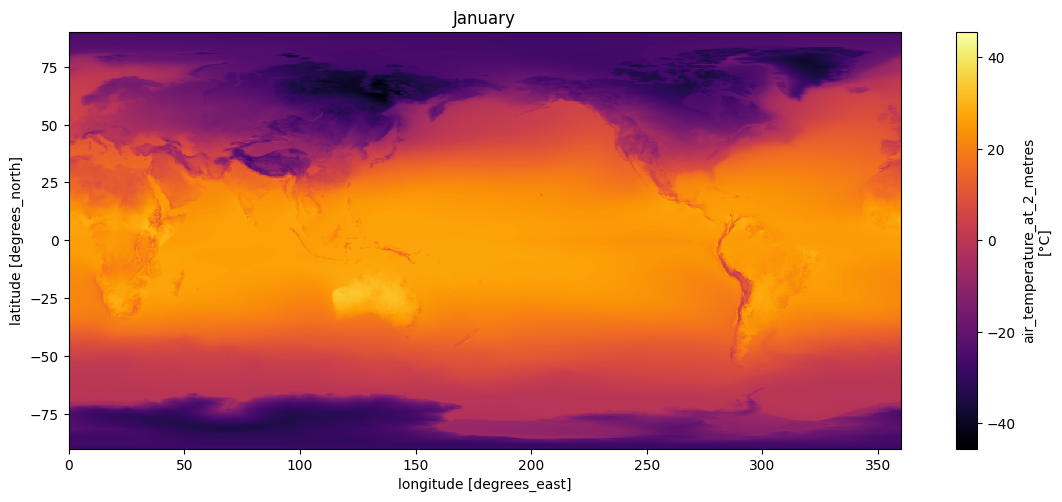

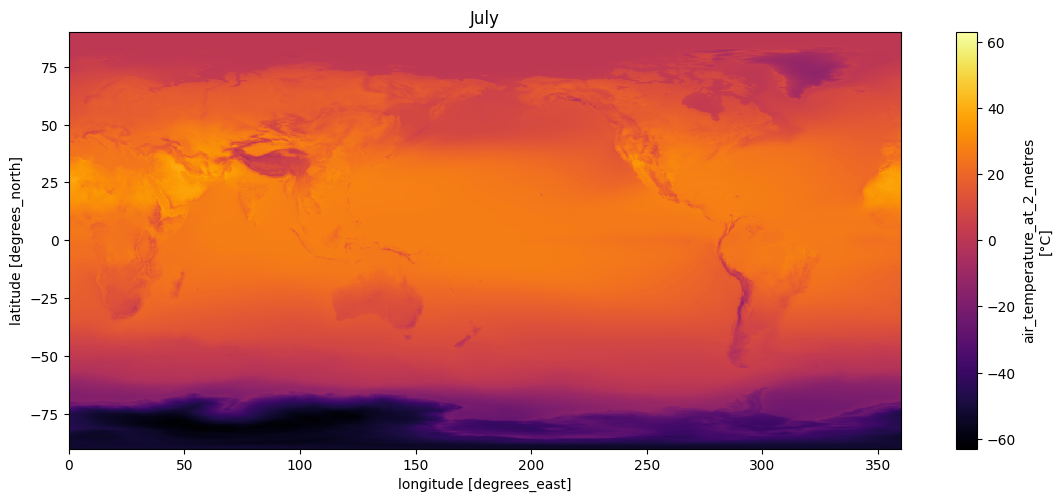

In [13]:
plot_map(temperature, cmap='inferno')

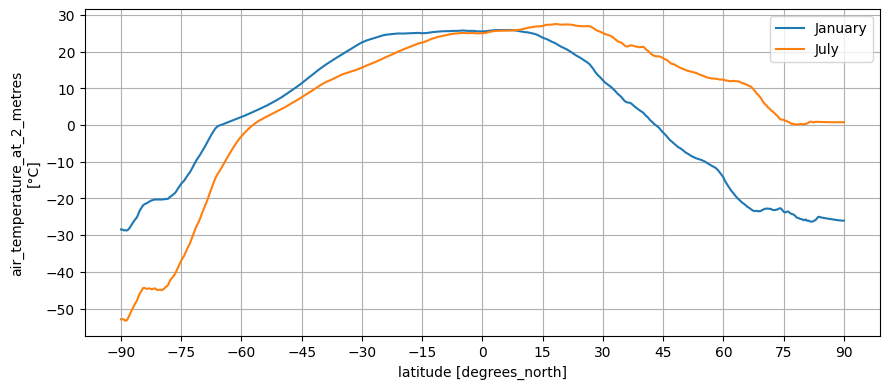

In [24]:
plot_by_lat(temperature)

# Precipitation

In [15]:
precipitation = (average_by_month(YEARS, MONTHS, 'precipitation_amount_1hour_Accumulation') * 24 * 365).rename('precipitation').assign_attrs(units='m/y')

  0%|          | 0/20 [00:00<?, ?it/s]

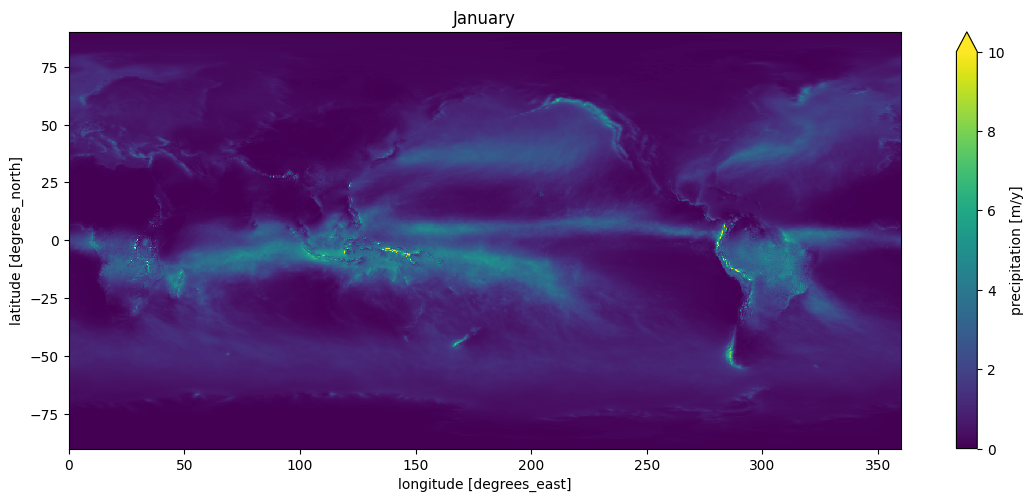

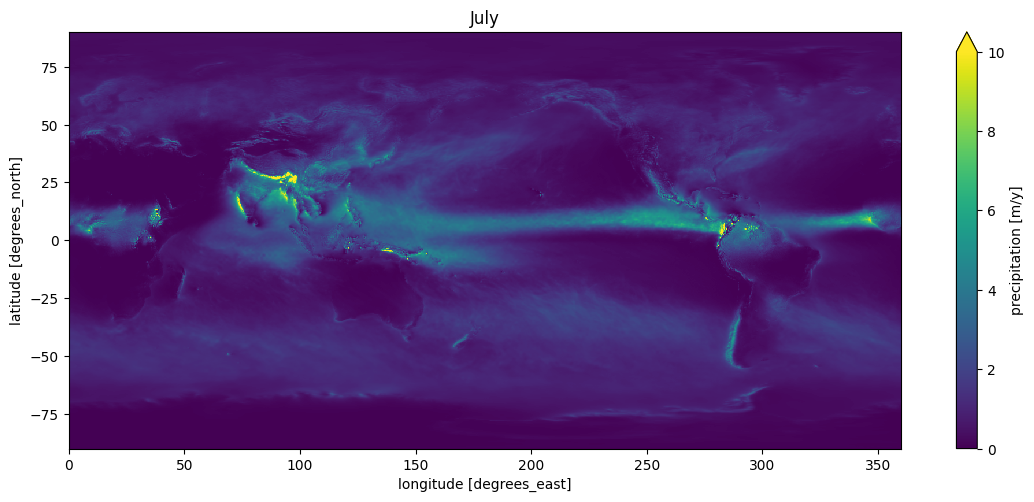

In [27]:
plot_map(precipitation, vmin=0.0, vmax=10.0)

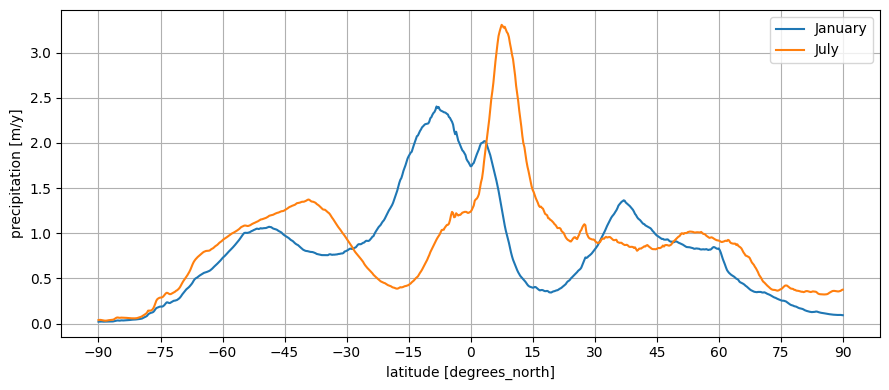

In [28]:
plot_by_lat(precipitation)